# Imports

In [ ]:
import os
os.system('pip install opencv-python numpy pandas tqdm matplotlib')
os.system('pip install scipy scikit-learn seaborn')

In [1]:
import cv2, glob, tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks, savgol_filter
from scipy.stats import kurtosis
from scipy.stats import ttest_ind, pearsonr
from sklearn.utils import resample

from utils.descriptors import *

# Functions

In [2]:
def patchesHotEncoding(classes, counts):
    ''' Hot encoding of the annotated classes '''

    existing_classes = np.unique(np.concatenate(classes))
    hot_encoding = []

    for cla, cou in zip(classes, counts):
        encoding = []
        for class_ in existing_classes:
            val = cou[cla == class_]
            if len(val > 1):
                encoding.append(int(val[0]/10))
            else:
                encoding.append(0)
        hot_encoding.append(encoding)
    
    return np.asarray(hot_encoding)

def getKcoef(feat, n_bins=32, window_length=3):
    ''' Compute the kappa-coefficient for figurative diversity '''
    
    values, bins = np.histogram(feat, bins=n_bins)
    minimas = find_peaks(-savgol_filter(values, window_length, polyorder=1))[0].tolist() + [n_bins]
    
    weights, stds, kurtoses = [], [], []
    prev_thr = bins[0]-(1e-5)

    for i, minima in enumerate(minimas):
        thr = bins[minima]
        f = feat[(feat > prev_thr) & (feat <= thr)]
        f = np.concatenate([f, bins])
        weights.append(len(f)/len(feat))
        kurtoses.append(kurtosis(f))
        prev_thr=thr
        
    weights, kurtoses = np.array(weights), np.array(kurtoses)
    
    return np.sum(weights[weights > 0]*kurtoses[weights > 0])

def averageResampledK(original_sample, resample_size, n=1000):
    ''' Resample the kappa coefficient '''
    
    Kcoefs = []

    for i in range(n):
        resampled = resample(original_sample, replace=False, n_samples=resample_size)
        K = [getKcoef(resampled[:,i]) for i in range(original_sample.shape[1])]
        Kcoefs.append(K)
        
    return np.median(np.asarray(Kcoefs), axis=0).tolist()

def cutTexels(image):
    ''' Cut images into texels '''
    
    if len(image.shape) > 2:
        dimension = image.shape[2]
    else:
        dimension = 1
        
    img = image.copy()
    shape = img.shape[:2]
    
    # Crop if not divisible by patch size
    if shape[0]%patch_size > 0:
        img = img[:-(shape[0]%patch_size)]
    if shape[1]%patch_size > 0:
        img = img[:, :-(shape[1]%patch_size)]
        
    return img.reshape((shape[0]//patch_size, patch_size, shape[1]//patch_size, patch_size, dimension))

# Global variables

In [3]:
dataset_path_prefix = 'dataset'
patch_size = 50
datasets = ['paris', 'world']
comparison_datasets = ['icdar21', 'usgs', 'napoleonic']

# Script
## Compute figurative features

We provide you with the code to compute the figurative features on the dataset described in the article, downloadable [on this link](https://zenodo.org/record/5497934). For all the datasets, including the comparison datasets, the features have been pre-computed to allow you to reproduce our experiments. Thus, you can also decide to go directly to the next section, which will save you about 20 minutes of computation.

In [4]:
features, classes, counts = {}, {}, {}
for dataset in datasets:
    features[dataset], classes[dataset], counts[dataset] = [], [], []
    
    # Load image and label patches
    images_paths = glob.glob(f'{dataset_path_prefix}/{dataset}/images/*.png') + glob.glob(
        f'{dataset_path_prefix}/{dataset}/eval/images/*.png')
    labels_paths = glob.glob(f'{dataset_path_prefix}/{dataset}/labels/*.png') + glob.glob(
        f'{dataset_path_prefix}/{dataset}/eval/labels/*.png')
    
    #for image_path, label_path in tqdm.tqdm(zip(images_paths, labels_paths)):
    for image_path, label_path in tqdm.tqdm(zip(images_paths, labels_paths)):
        
        # Split the patches into smaller texels, typically around 50x50 px
        image = cutTexels(cv2.imread(image_path))
        label = cutTexels(cv2.imread(label_path, 0))
        
        # Iterate over texels
        for i in range(image.shape[0]):
            for j in range(image.shape[2]):
                unique_labels, unique_counts = np.unique(label[i, :, j], return_counts=True)
                patch = image[i, :, j]
                
                # Compute HOG features and re-bin them
                hog = getHOGdescriptors(patch)
                hog = np.concatenate((np.asarray([hog[:,0]]).T, np.asarray([hog[:,12]]).T, 
                                np.asarray([hog[:,6]+hog[:,18]]).T, 
                                np.asarray([hog[:,4]+hog[:,8]+hog[:,16]+hog[:,22]]).T, np.asarray(
                    [hog[:,1]+hog[:,2]+hog[:,3]+hog[:,5]+hog[:,7]+hog[:,9]+hog[:,10]+hog[:,11]+hog[:,13]+\
                     hog[:,14]+hog[:,15]+hog[:,17]+hog[:,19]+hog[:,21]+hog[:,22]+hog[:,23]]).T), axis=1)
                
                # Compute color and texture features. Merge all features
                feat = np.concatenate([getColorDescriptors(patch), getLBPdescriptors(patch), hog], axis=-1)
                features[dataset].append(feat[0])
                classes[dataset].append(unique_labels)
                counts[dataset].append(unique_counts)

    # Save the computed features
    os.makedirs('export', exist_ok=True)
    np.save(f'export/{dataset}_features.npy', features[dataset])
    np.save(f'export/{dataset}_classes.npy', classes[dataset])
    np.save(f'export/{dataset}_counts.npy', counts[dataset])

330it [07:47,  1.42s/it]
/Users/remipetitpierre/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
305it [07:10,  1.41s/it]


## Load figurative features and compute resulting kappa-coef

In [5]:
# Load all pre-computed features
hot_encoding, compact_features, features, classes, counts = {}, {}, {}, {}, {}
for dataset in datasets:
    features[dataset] = np.load(f'export/{dataset}_features.npy')
    classes[dataset] = np.load(f'export/{dataset}_classes.npy', allow_pickle=True)
    counts[dataset] = np.load(f'export/{dataset}_counts.npy', allow_pickle=True)
    hot_encoding[dataset] = patchesHotEncoding(classes[dataset], counts[dataset])
    compact_features[dataset] = compactFeat(features[dataset])
    
for dataset in comparison_datasets:
    features[dataset] = np.load(f'export/{dataset}_features.npy')
    compact_features[dataset] = compactFeat(features[dataset])

In [14]:
# Find the length of the smallest dataset
compact_features_len = [len(val) for val in compact_features.values()]
min_len, argmin_len = np.min(compact_features_len), np.argmin(compact_features_len)

# Compute the κ-coefficients
data = {}
for i, dataset in enumerate(datasets + comparison_datasets):
    
    # If the dataset is longer than the smallest dataset, resample and compute the κ-coefficient
    if i != argmin_len:
        data_kappa = averageResampledK(compact_features[dataset], min_len, 5000)
        
    # If the dataset is the smallest dataset, don't resample, just compute the κ-coefficient
    else:
        data_kappa = [getKcoef(compact_features[dataset][:,i], 32) for i in range(14)]
    
    data[dataset] = data_kappa + [data_kappa[0]]
    print(dataset.ljust(12), np.median(data[dataset][:-1]))

paris        1.9667740987170004
world        1.9919503238838616
icdar21      5.039244886154177
usgs         29.120288697259774
napoleonic   4.363625241130702


In [7]:
# Separate the features by class for both dataset and downsample
sample_size = np.min([np.sum(hot_encoding['world'][:,i] > (250*0.75)) for i in range(5)])
resampled_w = [resample(features['world'][hot_encoding['world'][:,i] > (250*0.75)], 
                        n_samples=sample_size, replace=False) for i in range(5)]
sample_size = np.min([np.sum(hot_encoding['paris'][:,i] > (250*0.75)) for i in range(5)])
resampled_p = [resample(features['paris'][hot_encoding['paris'][:,i] > (250*0.75)], 
                        n_samples=sample_size, replace=False) for i in range(5)]

In [8]:
# Compute the aggregated  correlation  heatmap  matrix  of  intra-corpus  inter-class  correlation  
# (top-right for the World, down-left for Paris) and inter-corpus class correlation (diagonal).

corr_matrix = np.zeros((5, 5))
for j in range(5):
    for k in range(5):
        if j > k:
            corr_matrix[j, k] = pearsonr(np.concatenate([np.histogram(resampled_w[j][:,i], bins=32)[0] for i in range(14)]), 
                        np.concatenate([np.histogram(resampled_w[k][:,i], bins=32)[0] for i in range(14)]))[0]
            
        elif j < k:
            corr_matrix[j, k] = pearsonr(np.concatenate([np.histogram(resampled_p[j][:,i], bins=32)[0] for i in range(14)]), 
                        np.concatenate([np.histogram(resampled_p[k][:,i], bins=32)[0] for i in range(14)]))[0]
        else:
            corr_matrix[j, j] = pearsonr(np.concatenate([np.histogram(resampled_p[j][:,i], bins=32)[0] for i in range(14)]), 
                        np.concatenate([np.histogram(resampled_w[j][:,i], bins=32)[0] for i in range(14)]))[0]

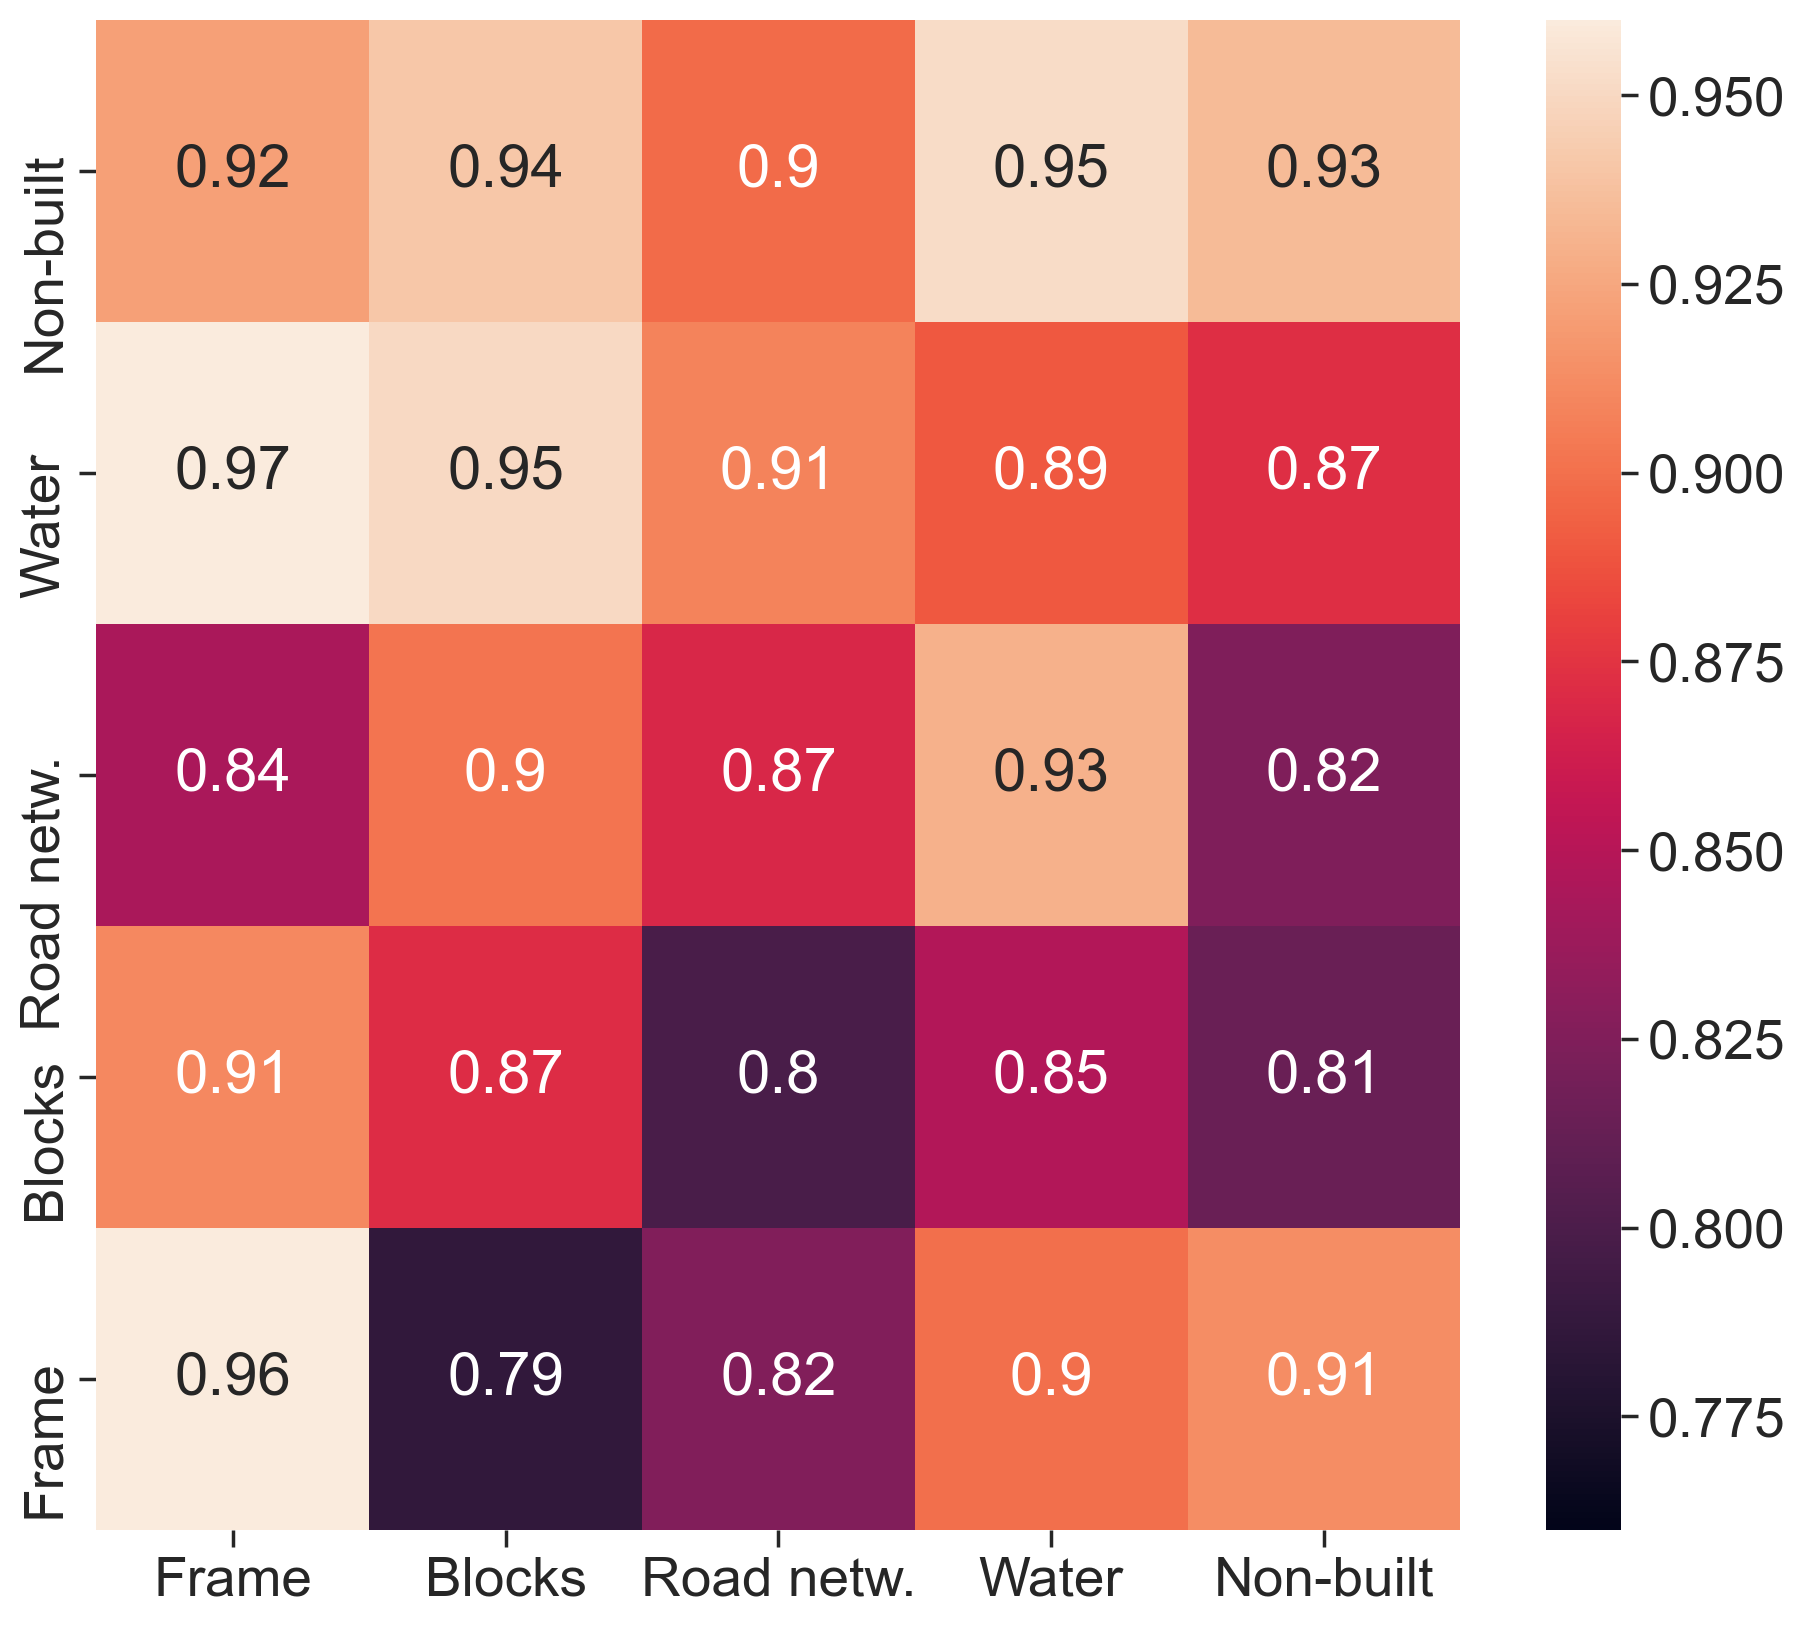

In [9]:
# Plot the correlation matrix
# Notice that due to the random sample, you may get a slightly different result
sns.set(rc={'figure.figsize':(11,10), 'figure.dpi': 200})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.8)
labels = ['Frame', 'Blocks', 'Road netw.', 'Water', 'Non-built']

sns.heatmap(corr_matrix, annot=True, yticklabels = labels, xticklabels = labels, vmin=0.76, vmax=0.96).set(
    xlim=(0,5),ylim=(0,5));